##EDA

1. Class imbalance: shows us to SMOTE the features
2. Redispatch against time: shows us that there are no seasonlities or similiar - so does not make sense to include any timeseries elements as features
3. (partial) Autocorrelations : shows us to lagg the features
4. Features

In [1]:
# packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import datetime as dt
import matplotlib
import statsmodels.api as sm
import scipy.stats as ss

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

In [2]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# searching for files, load data and convert index to datetime type

def search_file(directory, filename):
    for root, dirs, files in os.walk(directory):
        if filename in files:
            return os.path.join(root, filename)
    return None

search_directory = '/content/drive/My Drive'
file_name = 'curtailment_target_features.csv'
file_path = search_file(search_directory, file_name)

df = pd.read_csv(file_path, sep = ';', index_col=0)
df.index = pd.to_datetime(df.index)

##**1. Class Imbalance**

By counting the bivariate target variable, it becomes clear that the case of curtailment occurs significantly less frequently than no curtailment. This high class imbalance may bias the model towards the majority class, leading to poor performance for the minority class.

redispatch
0.0    131810
1.0      8398
Name: count, dtype: int64


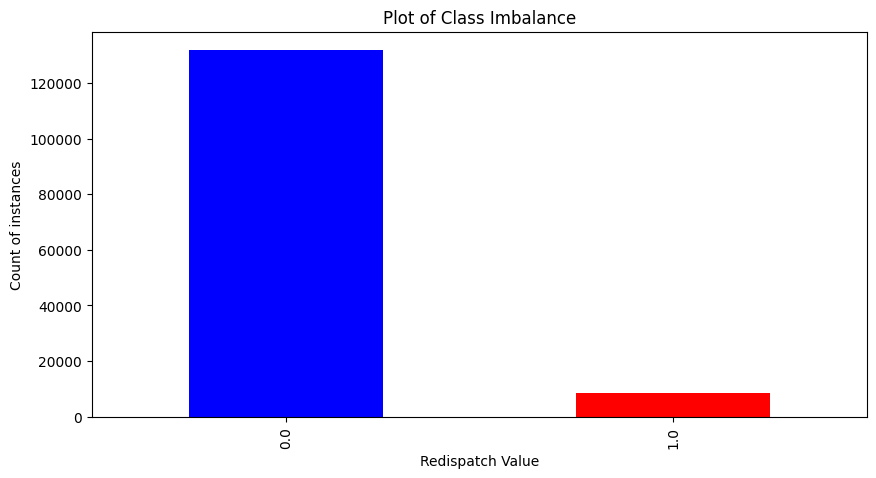

In [6]:
# number count
print(df.redispatch.value_counts())

# plot
df.redispatch.value_counts().plot(kind='bar', figsize=(10, 5), color=['blue', 'red'])
plt.xlabel('Redispatch Value')
plt.ylabel('Count of instances')
plt.title('Plot of Class Imbalance')
plt.show()

##**2. Redispatch**

1. Redispatch values over time
2. Summary statistics over time
3. Autocorrelation

**1. Redispatch values over time**

In [45]:
def redispatch_time_plot(df, start_date, end_date):
  """ plots the redispatch status agaist the specified timeframe """
  start_date = start_date
  end_date = end_date
  df_selected = df.loc[start_date:end_date]
  df_selected['redispatch'].plot(figsize=(10, 5))
  plt.gcf().autofmt_xdate()
  plt.xlabel('Date')
  plt.ylabel('Redispatch')
  plt.title('Redispatch over time')
  plt.show()


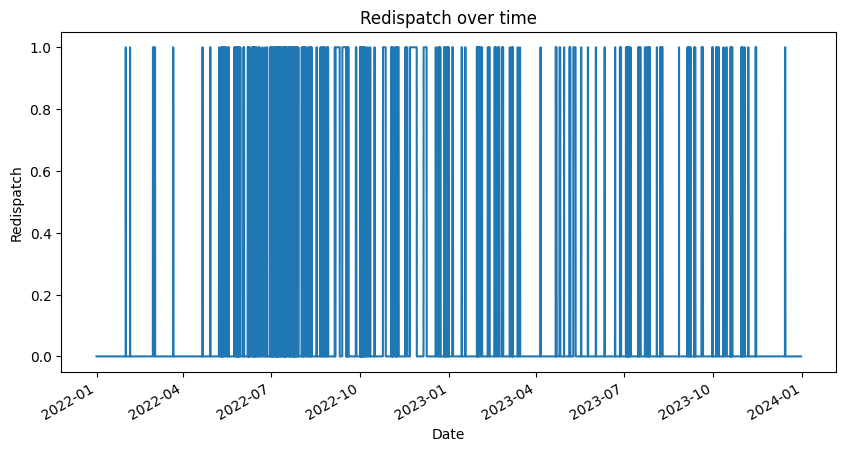

In [46]:
# over a year
redispatch_time_plot(df, '2022-01-01', '2023-12-31')

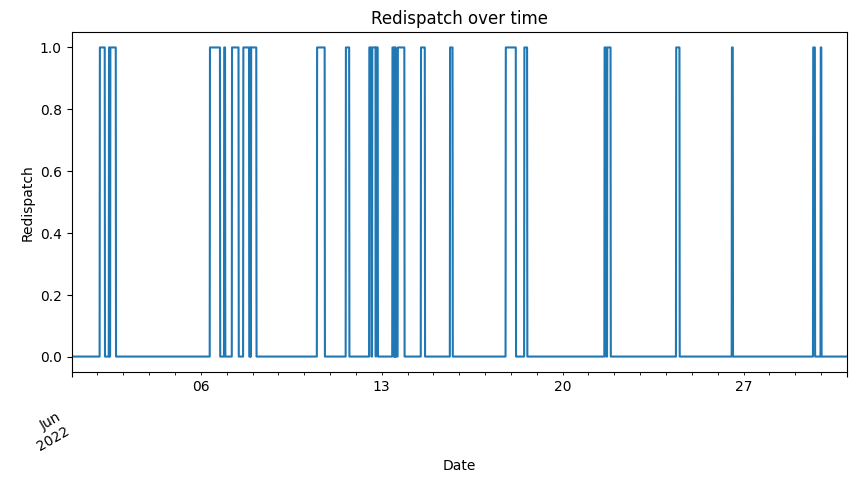

In [18]:
# over a month
redispatch_time_plot(df, '2022-06-01', '2022-06-30')

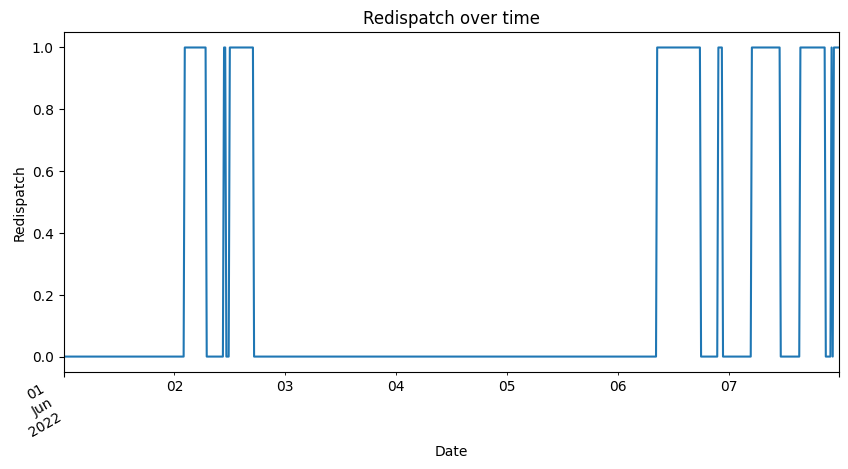

In [19]:
# over a week
redispatch_time_plot(df, '2022-06-01', '2022-06-07')

**2. Summary Statistics over time**

In [39]:
def redispatch_stats_plot(df, interval):
  """Calculates the summary statistics of the given time interval and plots it over time."""
  summary = df['redispatch'].resample(interval).agg(['mean', 'median', 'var'])
  summary.plot(title='Summary Statistics', figsize=(10, 5))
  plt.xlabel('Date')
  plt.ylabel('Value')
  plt.legend(['Mean', 'Median', 'Variance'])
  plt.show()

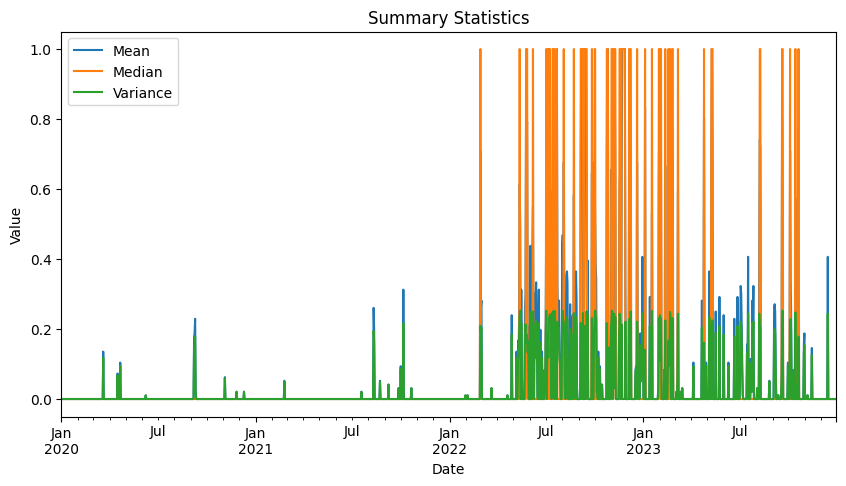

In [40]:
# daily
redispatch_stats_plot(df, 'D')

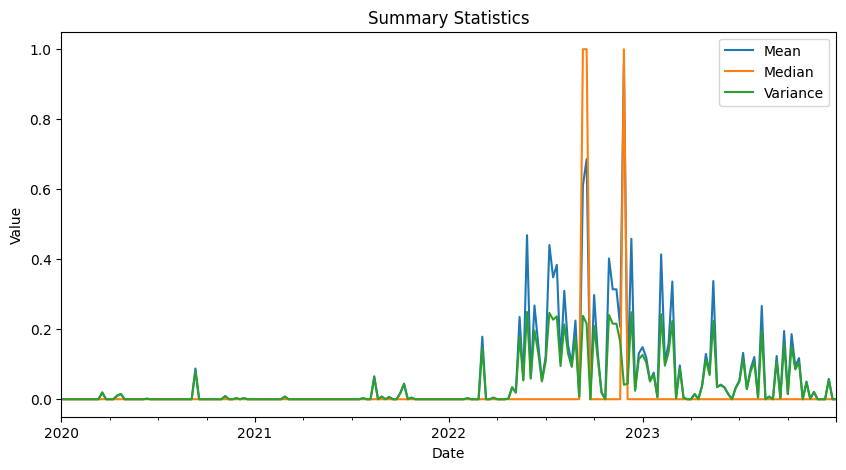

In [41]:
# weekly
redispatch_stats_plot(df, 'W')

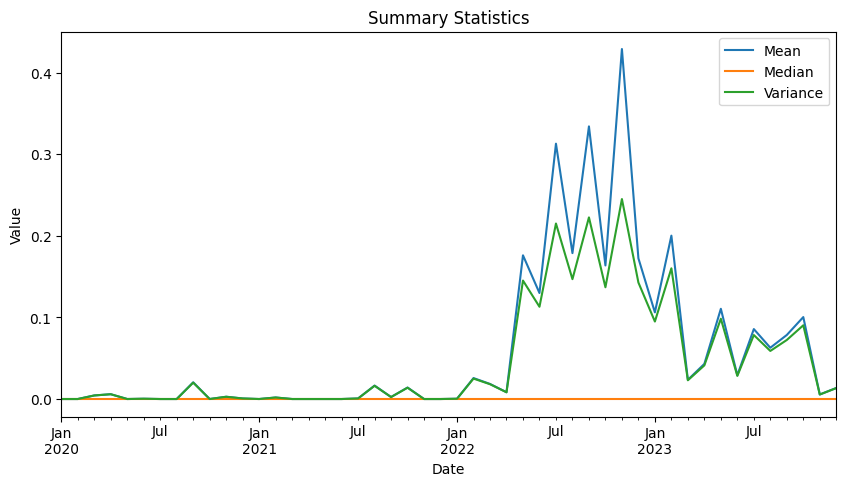

In [42]:
# weekly
redispatch_stats_plot(df, 'M')

**3. (partial) Autocorrelation**

Autocorrelation measures the degree of similarity between a time series and a lagged version of itself over successive time intervals. It provides us insights into the temporal dependencies of the target variable.

Partial autocorrelation measures the correlation between a variable and a lagged version of itself, controlling for the intervening lags. In other words, it quantifies the relationship between two observations in a time series while removing the influence of the intermediate observations

<Figure size 1000x600 with 0 Axes>

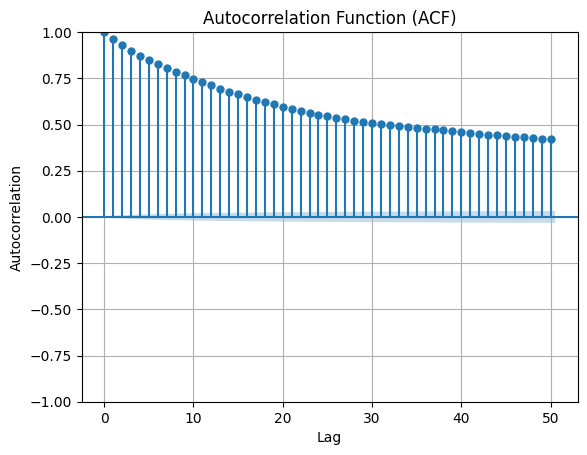

Autocorrelation: 0.960101247666363


In [ ]:
# Calculate autocorrelation function (ACF) and plot
acf = pd.Series(data=df['redispatch']).autocorr()

plt.figure(figsize=(10, 6))
plot_acf(df['redispatch'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

print("Autocorrelation:", acf)

In [ ]:
# Plot partial autocorrelation function for each feature
for feature in df.columns:
    plt.figure(figsize=(12, 6))
    plot_pacf(df[feature], lags=10)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.title(f'Partial Autocorrelation Plot for {feature}')
    plt.show()

**4. Features**

ANOVA

ANOVA feature selection is a statistical method to pinpoint significant features by analyzing how a numerical variable varies across different categories of a categorical variable. It calculates the F-statistic to assess the difference in means between groups. A low p-value suggests at least one group's mean significantly differs from others, rejecting the null hypothesis of no difference.

In [50]:
def anova_pvalues(df, cat_col, num_cols):
    """
    This function calculates the ANOVA p-values (probability of no correlation)
    between a categorical column and multiple numerical columns of a DataFrame.
    """
    p_values = {}
    for num_col in num_cols:
        CategoryGroupLists = df.groupby(cat_col)[num_col].apply(list)
        AnovaResults = ss.f_oneway(*CategoryGroupLists)
        p_value = round(AnovaResults[1], 3)
        p_values[num_col] = p_value

    return p_values

In [51]:
numeric_columns = df.drop('redispatch', axis = 1).columns
p_values = anova_pvalues(df, 'redispatch', numeric_columns)

# Print the p-values for each numeric column
for num_col, p_value in p_values.items():
    print(f"p-value {num_col}: {p_value}")

p-value level: 0.0
p-value wind_speed_m/s: 0.0
p-value wind_direction_degrees: 0.0
p-value radiation_global_J/m2: 0.0
p-value air_temperature_K: 0.0
p-value humidity_percent: 0.0
p-value wind_gust_max_m/s: 0.0
p-value wind_direction_gust_max_degrees: 0.0
p-value forecast_solar_MW: 0.0
p-value total_grid_load_MWh: 0.0
p-value residual_load_MWh: 0.0
p-value pumped_storage_MWh: 0.0


**Multicollinearity between features**

Variance Inflation Factor (VIF)

VIF measures the extent to which the variance of an estimated regression coefficient increases if your predictors are correlated. High VIF values indicate that a predictor may be too highly correlated with other predictors in the model, potentially leading to multicollinearity issues.

'wind_speed_m/s', 'wind_gust_max_m/s' indicate potential multicollinearity issues

In [52]:
X = df.drop('redispatch', axis=1)
X_with_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)


                            Feature          VIF
0                             const  3105.630084
1                             level     1.007630
2                    wind_speed_m/s    44.255519
3            wind_direction_degrees     9.205091
4             radiation_global_J/m2     6.174555
5                 air_temperature_K     1.457142
6                  humidity_percent     1.980635
7                 wind_gust_max_m/s    45.489999
8   wind_direction_gust_max_degrees     9.221676
9                 forecast_solar_MW     5.689605
10              total_grid_load_MWh     1.977689
11                residual_load_MWh     2.157219
12               pumped_storage_MWh     1.375341


Further investigate the multicollinearity between the variables 'wind_speed_m/s', 'wind_gust_max_m/s', and 'forecast_solar_MW' using

1. Correlation Matrix: Calculate the correlation coefficients between these variables to identify pairs with high correlation.
2. VIF Diagnostic: Compute the Variance Inflation Factor (VIF) for each variable to quantify multicollinearity.
3. Pairwise Scatterplots: Create scatterplots between pairs of variables to visually inspect their relationship.
4. Principal Component Analysis (PCA): Perform PCA to transform the variables into uncorrelated principal components.

In [58]:
variables_of_interest = ['wind_speed_m/s', 'wind_gust_max_m/s']
subset_df = df[variables_of_interest]

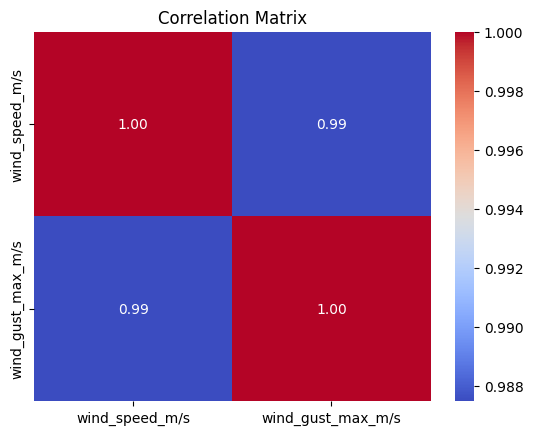

In [59]:
# 1. Correlation Matrix
correlation_matrix = subset_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [60]:
# 2. VIF Diagnostic
X_with_const = sm.add_constant(subset_df)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)

             Feature        VIF
0              const   4.016376
1     wind_speed_m/s  40.190225
2  wind_gust_max_m/s  40.190225


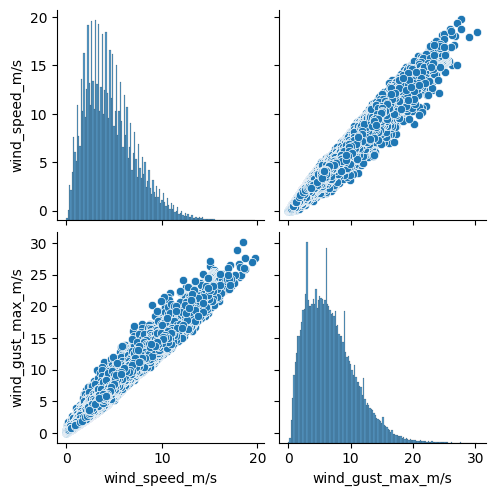

In [61]:
# 3. Pairwise Scatterplots
sns.pairplot(subset_df)
plt.show()

In [62]:
# 4. Principal Component Analysis (PCA)
pca = PCA().fit(subset_df)
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.99461598 0.00538402]


PCA

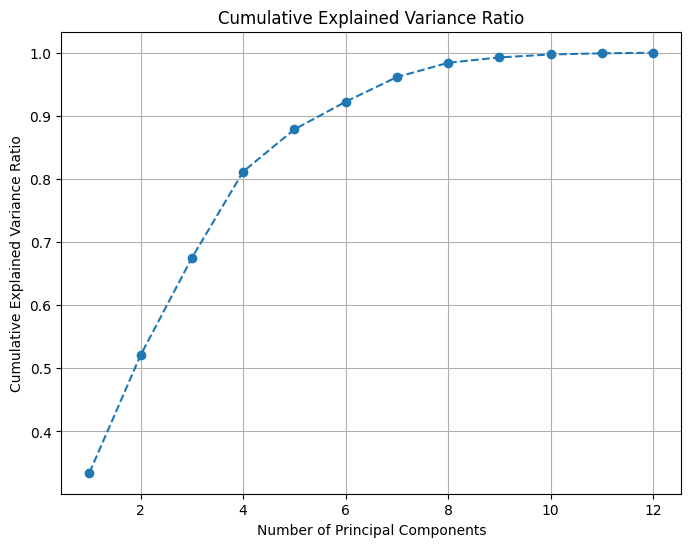

Top contributing features for each principal component:
     actual_solar_MW  air_temperature_K  forecast_solar_MW  humidity_percent  \
PC1         0.462824           0.288949           0.456666          0.375431   
PC2         0.157396           0.142027           0.153628          0.111643   
PC3         0.005622           0.010049           0.006249          0.013598   
PC4         0.072800           0.143661           0.074658          0.047447   
PC5         0.175978           0.685654           0.184633          0.183861   
PC6         0.041456           0.623523           0.016931          0.461677   
PC7         0.224642           0.021043           0.279096          0.724531   

     pumped_storage_MWh  radiation_global_J/m2  residual_load_MWh  \
PC1            0.083326               0.456941           0.133388   
PC2            0.136176               0.156783           0.243843   
PC3            0.470262               0.025378           0.534281   
PC4            0.255396    

In [ ]:
# Extract features (X) and target variable (y)
X = df.drop(columns=['redispatch'])
y = df['redispatch']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA
pca = PCA()

# Fit PCA to the standardized features
pca.fit(X_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Choose the number of components based on the plot or a desired threshold
# For example, if 95% of variance is explained
n_components = (explained_variance_ratio.cumsum() < 0.95).sum() + 1

# Initialize PCA with the chosen number of components
pca = PCA(n_components=n_components)

# Fit PCA to the standardized features
X_pca = pca.fit_transform(X_scaled)

# Convert transformed data to a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])

# Get the absolute values of loadings for each component
abs_loadings = np.abs(pca.components_)

# Create a DataFrame to store the loadings
loadings_df = pd.DataFrame(abs_loadings, columns=X.columns, index=[f'PC{i+1}' for i in range(abs_loadings.shape[0])])

# Sort the loadings for each component in descending order
sorted_loadings = loadings_df.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Print the top contributing features for each component
print("Top contributing features for each principal component:")
print(sorted_loadings)

# Concatenate PCA-transformed features with the target variable
df_pca = pd.concat([X_pca_df, y.reset_index(drop=True)], axis=1)

# Now you can use df_pca for further analysis or modeling


Feature importance

1. feature importance through linear models
2. feature importance through tree based models
3. feature importance through permutation
Ensemble Methods: Combining results from multiple feature importance methods or ensembling feature selection techniques can provide a more comprehensive assessment of feature relevance.

In [ ]:
X = df.drop('redispatch', axis=1)
y = df['redispatch']

In [ ]:
#Feature importance through permutation

# Define your classifier
clf = RandomForestClassifier()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize lists to store feature importances
all_feature_importances = []

# Perform Time Series Cross Validation
for i, (train_index, test_index) in enumerate(tscv.split(X), 1):
    print(f"Processing split {i}/{tscv.n_splits}")
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Balance the classes using SMOTE
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Fit your classifier to the balanced training data
    clf.fit(X_train_balanced, y_train_balanced)

    # Calculate permutation importance
    perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

    # Get feature importances
    feature_importances = perm_importance.importances_mean

    # Append feature importances to the list
    all_feature_importances.append(feature_importances)

    # Get feature names
    feature_names = X.columns

    # Combine feature names and their importances
    feature_importance_dict = dict(zip(feature_names, feature_importances))

    # Sort features by importance
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Print or visualize sorted feature importances
    for feature, importance in sorted_feature_importance:
        print(f"{feature}: {importance}")

# Calculate average feature importance across all folds
avg_feature_importances = np.mean(all_feature_importances, axis=0)

# Get feature names
feature_names = X.columns

# Combine feature names and their importances
feature_importance_dict = dict(zip(feature_names, avg_feature_importances))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or visualize sorted feature importances
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Processing split 1/5
wind_direction_degrees: 0.0001754536117767991
air_temperature_K: 0.00012410133515921017
total_grid_load_MWh: 8.55871276959852e-05
wind_direction_gust_max_degrees: 6.84697021568037e-05
pumped_storage_MWh: 5.1352276617577794e-05
humidity_percent: 2.5676138308783347e-05
wind_speed_m/s: 2.5676138308772244e-05
forecast_solar_MW: 2.1396781923987974e-05
actual_solar_MW: 1.2838069154397225e-05
radiation_global_J/m2: 8.558712769590749e-06
residual_load_MWh: 8.558712769590749e-06
wind_gust_max_m/s: 0.0
Processing split 2/5
air_temperature_K: 4.7072920232782424e-05
pumped_storage_MWh: -0.00021824717562484163
total_grid_load_MWh: -0.0004364943512496167
humidity_percent: -0.0006033892502568028
residual_load_MWh: -0.0008344744950359861
wind_direction_gust_max_degrees: -0.0010826771653543953
wind_direction_degrees: -0.001172543649435176
wind_gust_max_m/s: -0.001193940431359186
wind_speed_m/s: -0.001215337213283163
radiation_global_J/m2: -0.0017716535433071057
forecast_solar_MW: -

In [ ]:
feature_importance_df = pd.DataFrame.from_dict(feature_importance_dict, orient='index', columns=['Importance'])
# Reset the index to a new column named 'Feature'
feature_importance_df = feature_importance_df.reset_index()

# Rename the columns to match your requirements
feature_importance_df.columns = ['Features', 'Importance']

feature_importance_df

,Features,Importance
0,wind_speed_m/s,0.262666
1,wind_direction_degrees,-0.290085
2,radiation_global_J/m2,-0.154403
3,air_temperature_K,0.109392
4,humidity_percent,0.008342
5,wind_gust_max_m/s,0.073411
6,wind_direction_gust_max_degrees,0.335428
7,forecast_solar_MW,0.977399
8,actual_solar_MW,-0.059727
9,total_grid_load_MWh,0.171309


In [ ]:
#feature importance through linear models like logistic regression

# Define your classifier (Logistic Regression)
clf = LogisticRegression()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Initialize lists to store feature importances and their names
feature_importances_list = []
feature_names = X.columns

# Initialize pipeline
pipeline = Pipeline([('scaler', scaler), ('smote', smote), ('clf', clf)])

# Perform Time Series Cross Validation
for i, (train_index, test_index) in enumerate(tscv.split(X), 1):
    print(f"Processing split {i}/{tscv.n_splits}")
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Store the feature importances
    feature_importances_list.append(pipeline.named_steps['clf'].coef_[0])

# Calculate mean feature importances across all splits
mean_feature_importances = np.mean(feature_importances_list, axis=0)

# Combine feature names and their importances
feature_importance_dict = dict(zip(feature_names, mean_feature_importances))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print or visualize sorted feature importances
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Processing split 1/5
Processing split 2/5
Processing split 3/5
Processing split 4/5
Processing split 5/5
forecast_solar_MW: 0.977398763498569
wind_direction_gust_max_degrees: 0.33542750732274285
wind_direction_degrees: -0.2900847188011352
wind_speed_m/s: 0.26266581511788767
total_grid_load_MWh: 0.17130884430970386
radiation_global_J/m2: -0.15440328223569377
air_temperature_K: 0.10939170161154718
wind_gust_max_m/s: 0.0734111285339134
residual_load_MWh: 0.06369026250772755
actual_solar_MW: -0.05972711370575773
humidity_percent: 0.008342446220673311
pumped_storage_MWh: 0.0069984996660245324


Understanding coefficients of logistic regression

Logistic Regression Coefficients: In logistic regression, we're trying to predict a binary outcome (like whether an email is spam or not spam) based on input variables (like email length, number of links, etc.). The coefficients in logistic regression tell us how each input variable contributes to the prediction.

Log Odds: Logistic regression uses a function called the logit function to convert the output into probabilities. So, the coefficients represent the log odds that an observation belongs to one of the classes (like spam or not spam).

Interpreting Coefficients: To interpret these coefficients, we need to convert them from log odds to regular odds. We do this by exponentiating them (using np.exp() in Python).

Example Interpretation: Let's say we're predicting whether a house will sell quickly based on features like the number of rooms and the level of pollution nearby. If the coefficient for the number of rooms is 2.0, it means that for every additional room, the odds of the house selling quickly are 2 times larger than the odds of it not selling quickly, assuming all other factors remain constant.

Negative Coefficients: If a coefficient is negative, it means that as the corresponding feature increases, the odds of the observation belonging to the target class decrease. We can interpret these by taking the reciprocal (1 divided by the odds), which gives us the odds of the observation not belonging to the target class.

In [ ]:
# Convert the dictionary to a DataFrame
values_feature_importance = pd.DataFrame.from_dict(feature_importance_dict, orient='index', columns=['Importance'])

# Reset the index to a new column named 'Feature'
values_feature_importance = values_feature_importance.reset_index()

# Rename the columns to match your requirements
values_feature_importance.columns = ['Features', 'Importance']


In [ ]:
values_feature_importance['Importance'] = values_feature_importance['Importance'].apply(np.exp)

values_feature_importance = values_feature_importance.sort_values(by='Importance', ascending=False)

values_feature_importance

,Features,Importance
7,forecast_solar_MW,2.657534
6,wind_direction_gust_max_degrees,1.398538
0,wind_speed_m/s,1.300392
9,total_grid_load_MWh,1.186857
3,air_temperature_K,1.115599
5,wind_gust_max_m/s,1.076173
10,residual_load_MWh,1.065762
4,humidity_percent,1.008377
11,pumped_storage_MWh,1.007023
8,actual_solar_MW,0.942022
